# IMPORTS and SETUP

In [4]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image

In [2]:
images = torch.load('data/kand_annotations/yolo_annotations/images.pt')
bboxes = torch.load('data/kand_annotations/yolo_annotations/bboxes.pt')

# DATA PROCESSING

In [6]:
num_images = images.size(0)

random.seed(3)
indices = list(range(num_images))
random.shuffle(indices)

train_split = int(0.85 * num_images)
val_split = int(0.90 * num_images)
train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

base_dir = 'yolo_dataset'
splits = {
    'train': train_indices,
    'val': val_indices,
    'test': test_indices
}

# Create folders for each split and subfolders for images and labels
for split in splits.keys():
    os.makedirs(os.path.join(base_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, split, 'labels'), exist_ok=True)

# Image dimensions and margin
img_width = img_height = 64
margin = 1  # number of pixels to keep inside the image boundaries

# Function to convert a tensor image to a PIL image
def tensor_to_pil(img_tensor):
    # img_tensor shape: [3, 64, 64] in float32 [0,1]
    img_np = img_tensor.mul(255).byte().numpy()  # convert to uint8
    # Convert from CHW to HWC format
    img_np = np.transpose(img_np, (1, 2, 0))
    return Image.fromarray(img_np)

# Function to convert and adjust a bounding box from [x, y, w, h] to YOLO format
def convert_bbox(bbox, img_width, img_height, margin=0):
    # bbox is assumed to be a tensor or array: [x, y, w, h]
    x, y, w, h = bbox.tolist()
    # Compute the intended end coordinates
    x_end = x + w
    y_end = y + h
    # If the end coordinates go beyond the image boundaries, adjust them to be inside by a margin
    if x_end >= img_width:
        x_end = img_width - margin
    if y_end >= img_height:
        y_end = img_height - margin
    # Recalculate width and height after adjusting the end coordinates
    w_adj = x_end - x
    h_adj = y_end - y
    # Compute YOLO format: normalized center coordinates and width/height
    x_center = (x + w_adj / 2) / img_width
    y_center = (y + h_adj / 2) / img_height
    return x_center, y_center, w_adj / img_width, h_adj / img_height

# Process each split and save images and labels
for split, idx_list in splits.items():
    for idx in idx_list:
        # Create a base filename (you can modify this as needed)
        filename = f"img_{idx:03d}"
        
        # Save image
        img = tensor_to_pil(images[idx])
        img_path = os.path.join(base_dir, split, 'images', filename + '.png')
        img.save(img_path)
        
        # Write label file for the corresponding bounding boxes
        label_lines = []
        # Loop over each of the 3 primitives (bounding boxes)
        for bbox in bboxes[idx]:
            # Convert bbox coordinates to YOLO format: [class, x_center, y_center, w, h]
            x_center, y_center, w_norm, h_norm = convert_bbox(bbox, img_width, img_height, margin)
            # Here we assign dummy class "0" for all boxes.
            line = f"0 {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}"
            label_lines.append(line)
        
        # Save label file
        label_path = os.path.join(base_dir, split, 'labels', filename + '.txt')
        with open(label_path, 'w') as f:
            f.write("\n".join(label_lines))

print("Dataset split and conversion (with bounding box adjustment) completed successfully!")


Dataset split and conversion (with bounding box adjustment) completed successfully!


# DATA CHECK (visual)

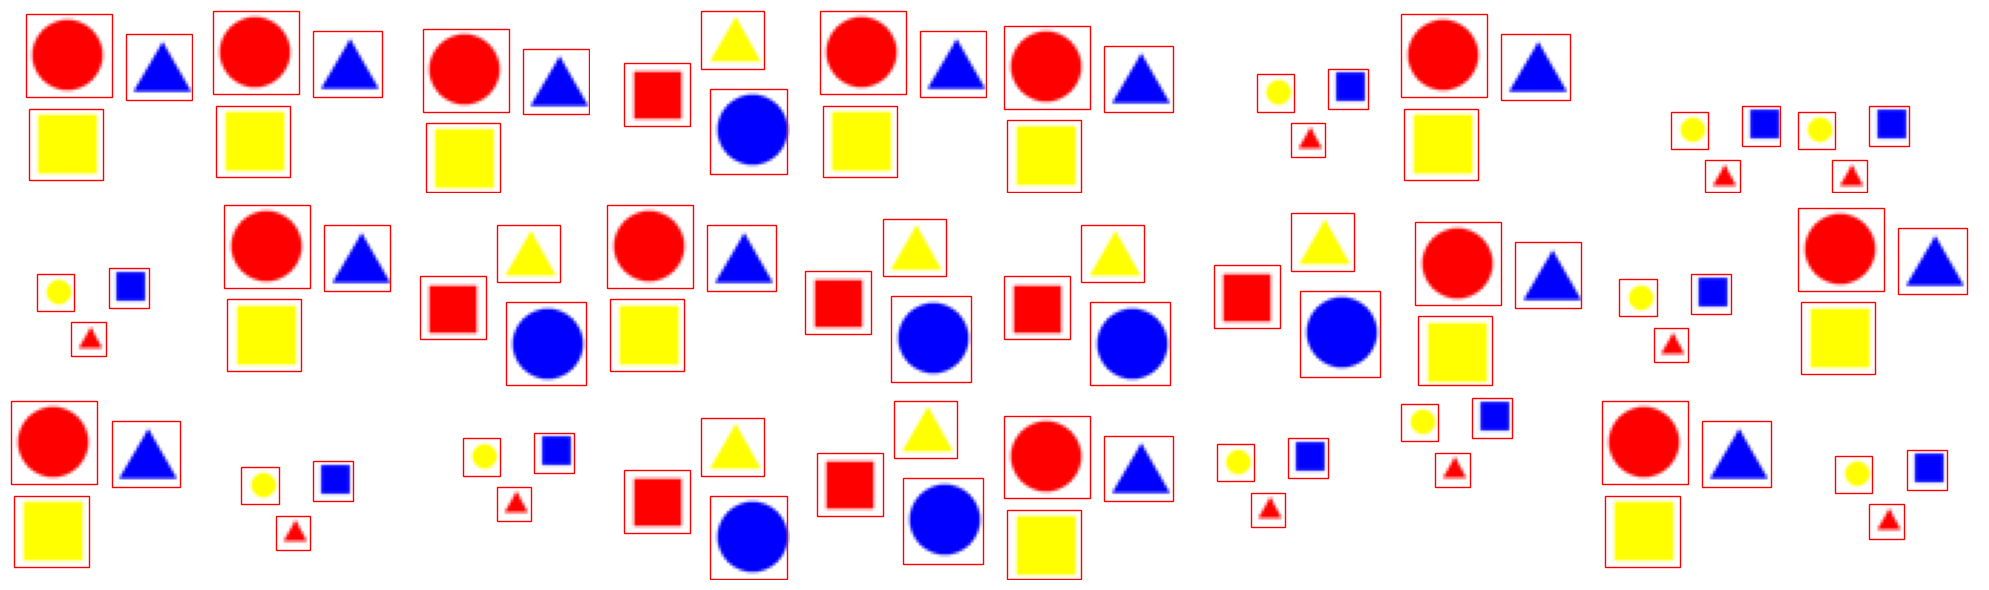

In [ ]:
# Set directories for training images and labels
train_images_dir = 'yolo_dataset/train/images'
train_labels_dir = 'yolo_dataset/train/labels'

# Get sorted list of image file names
all_images = sorted(os.listdir(train_images_dir))
# Ensure only image files are considered (e.g. .png)
all_images = [f for f in all_images if f.endswith('.png')]

# Randomly sample 30 images from train folder
selected_images = random.sample(all_images, 30)

# Prepare a 3 rows x 10 columns plot
fig, axes = plt.subplots(3, 10, figsize=(20, 6))

# Loop through the selected images and plot
for i, image_name in enumerate(selected_images):
    row = i // 10
    col = i % 10
    ax = axes[row, col]
    
    # Load image
    image_path = os.path.join(train_images_dir, image_name)
    img = Image.open(image_path)
    ax.imshow(img)
    ax.axis('off')
    
    # Read the corresponding label file (replace .png with .txt)
    label_name = image_name.replace('.png', '.txt')
    label_path = os.path.join(train_labels_dir, label_name)
    
    # Check if the label file exists
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
        # Each line in the label file is: class x_center y_center w h (normalized)
        for line in lines:
            parts = line.strip().split()
            # Here, we ignore the class label (parts[0]) as it's not important for visualization.
            x_center, y_center, w_norm, h_norm = map(float, parts[1:])
            # Convert normalized coordinates back to pixel coordinates
            img_w, img_h = img.size  # Should be 64x64 as per your data
            box_w = w_norm * img_w
            box_h = h_norm * img_h
            # Calculate top-left corner of the bounding box
            x = (x_center * img_w) - (box_w / 2)
            y = (y_center * img_h) - (box_h / 2)
            # Create and add a rectangle patch
            rect = patches.Rectangle((x, y), box_w, box_h, linewidth=1, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
    else:
        print(f"Warning: Label file {label_path} does not exist.")

plt.tight_layout()
plt.show()